In [2]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
import os
import tensorflow_datasets as tfds
%matplotlib inline
%load_ext tensorboard
%reload_ext tensorboard

### weather recognition dataset 
url  https://data.mendeley.com/datasets/4drtyfjtfy/1

In [506]:
DATASET_PATH = "./weather_dataset/"
NUM_CLASSES = 4
BATCH_SIZE = 8
results = [[] for x in range(3)]

In [6]:
print(tf.config.list_physical_devices("GPU"))
print(tf.config.list_logical_devices("CPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH + '/train/',
  batch_size = BATCH_SIZE,
)

Found 955 files belonging to 4 classes.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH + '/val/',
  batch_size = BATCH_SIZE,  
)

Found 170 files belonging to 4 classes.


In [10]:
class_names = train_ds.class_names
class_names

['cloudy', 'rain', 'shine', 'sunrise']

(256, 256, 3)


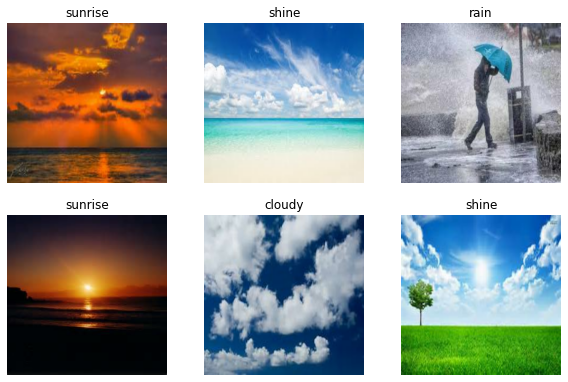

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images[0].shape)
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 256, 256, 3)
(8,)


In [23]:
logdir = "logs/alex-model-" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "models/alex/training__{epoch:02d}__{val_accuracy:.4f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy')

change_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0, **kwargs
)

In [236]:
alex_model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(256, 256, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(128, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(256, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(256, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
    # To Flatten layer
  tf.keras.layers.Flatten(),
    # To FC layer 1
  tf.keras.layers.Dense(64, activation='relu'),
    #To FC layer 2
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [239]:
alex_model.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
alex_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization_67 (Batc (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 31, 31, 128)       1486976   
_________________________________________________________________
batch_normalization_68 (Batc (None, 31, 31, 128)       512       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 31, 31, 256)       295168    
_________________________________________________________________
batch_normalization_69 (Batc (None, 31, 31, 256)      

In [26]:
with tf.device('/device:GPU:0'):
    alex_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback],
)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.1038 - accuracy: 0.6325
Epoch 00001: saving model to models/training__01__0.3176\cp.ckpt
120/120 [==============================] - 10s 82ms/step - loss: 1.1038 - accuracy: 0.6325 - val_loss: 1.3691 - val_accuracy: 0.3176
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.8304
Epoch 00002: saving model to models/training__02__0.4000\cp.ckpt
120/120 [==============================] - 8s 70ms/step - loss: 0.9366 - accuracy: 0.8304 - val_loss: 1.3328 - val_accuracy: 0.4000
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.8938 - accuracy: 0.8576
Epoch 00003: saving model to models/training__03__0.5471\cp.ckpt
120/120 [==============================] - 8s 71ms/step - loss: 0.8938 - accuracy: 0.8576 - val_loss: 1.1667 - val_accuracy: 0.5471
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.8838
Epoch 00004: saving 

In [5]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 11088), started 9:40:37 ago. (Use '!kill 11088' to kill it.)

## The best results of `Alex net` was in 20 epoch - validation accuracy `0.9` train accuracy `0.9864`

In [237]:
alex_model.load_weights('./models/alex/training__20__0.9000/cp.ckpt')

In [360]:
alex_model.evaluate(val_ds)

22/22 [==============================] - 1s 41ms/step - loss: 0.8577 - accuracy: 0.9000


[0.8577313423156738, 0.8999999761581421]

In [507]:
label_list = ['Cloudy','Rain','Shine', 'Sunrise']
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

def show_results_by_pictures(model,table_index=None):
    pictures_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      DATASET_PATH + '/test_pictures/',
      batch_size = BATCH_SIZE, 
      shuffle = False
    )
    normal_pictures_dataset = pictures_dataset.map(lambda x, y: (normalization_layer(x), y))
    model = model.predict(normal_pictures_dataset)
    revert_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.*255)
    revert_examples = normal_pictures_dataset.map(lambda x, y: (revert_layer(x), y))
    
    #draw
    plt.figure(figsize=(10, 10))
    for images, labels in revert_examples:
        for i in  range(5):
            ax = plt.subplot(5, 1, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(" ".join([ f"{x} - {model[i][ind]}"  for ind, x in enumerate(label_list)]) )
            plt.axis("off")
            



Found 5 files belonging to 4 classes.


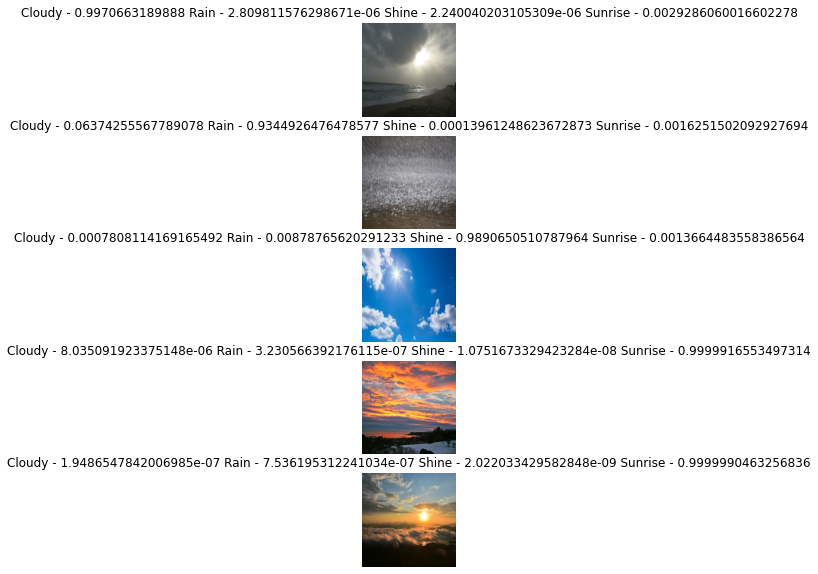

In [508]:
show_results_by_pictures(alex_model)

## VGG model

In [188]:
logdir = "logs/vgg-model-" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "models/vgg/training__{epoch:02d}__{val_accuracy:.4f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy')

In [189]:
vgg_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(input_shape=(256, 256, 3), filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  tf.keras.layers.ZeroPadding2D(padding=1),
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation="relu"),
  tf.keras.layers.Dense(units=256, activation="relu"),
  tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax")
])

In [190]:
vgg_model.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
vgg_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_48 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 256, 256, 32)      18464     
_________________________________________________________________
batch_normalization_49 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_50 (Batc (None, 128, 128, 64)     

In [191]:
with tf.device('/device:GPU:0'):
    vgg_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback],
)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.2187 - accuracy: 0.5435
Epoch 00001: saving model to models/vgg/training__01__0.2647\cp.ckpt
120/120 [==============================] - 18s 146ms/step - loss: 1.2187 - accuracy: 0.5435 - val_loss: 1.4430 - val_accuracy: 0.2647
Epoch 2/100
119/120 [============================>.] - ETA: 0s - loss: 1.0041 - accuracy: 0.7889
Epoch 00002: saving model to models/vgg/training__02__0.2647\cp.ckpt
120/120 [==============================] - 15s 127ms/step - loss: 1.0044 - accuracy: 0.7885 - val_loss: 1.4738 - val_accuracy: 0.2647
Epoch 3/100
119/120 [============================>.] - ETA: 0s - loss: 0.9732 - accuracy: 0.7889
Epoch 00003: saving model to models/vgg/training__03__0.4059\cp.ckpt
120/120 [==============================] - 15s 127ms/step - loss: 0.9733 - accuracy: 0.7885 - val_loss: 1.3155 - val_accuracy: 0.4059
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 0.9294 - accuracy: 0.8429
Epo

In [5]:
%tensorboard --logdir logs/ --host localhost

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7004.

## the best value of `VGG` model is validation  acc `0.9235` and  train acc - `0.8901`

In [194]:
vgg_model.load_weights('./models/vgg/training__12__0.9235/cp.ckpt')

In [204]:
vgg_model.evaluate(val_ds)

22/22 [==============================] - 1s 54ms/step - loss: 0.8488 - accuracy: 0.9235


[0.8487523794174194, 0.9235293865203857]

Found 5 files belonging to 4 classes.


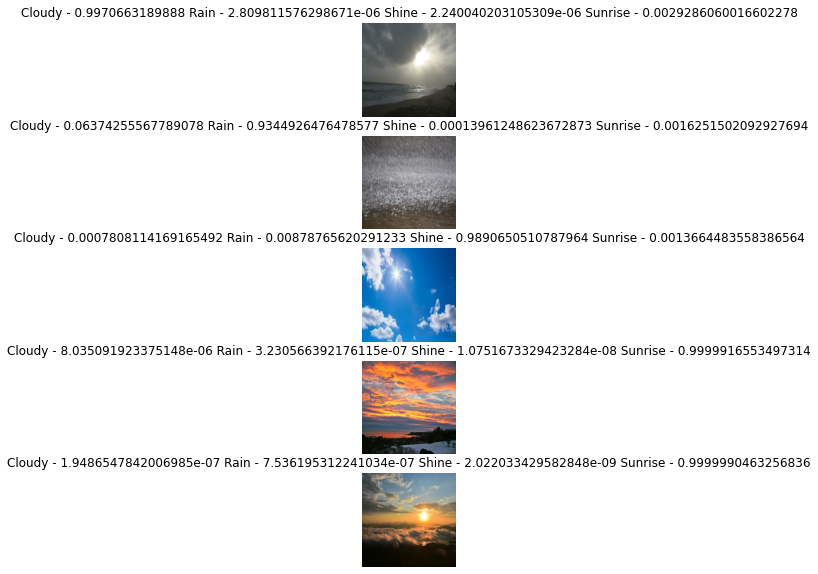

In [504]:
show_results_by_pictures(vgg_model)

## `Lenet` model

In [223]:
logdir = "logs/lenet-model-" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "models/lenet/training__{epoch:02d}__{val_accuracy:.4f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy')

In [224]:
lenet_model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(256, 256, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax'),
    ])

In [225]:
lenet_model.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
lenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 252, 252, 6)       456       
_________________________________________________________________
batch_normalization_63 (Batc (None, 252, 252, 6)       24        
_________________________________________________________________
activation_4 (Activation)    (None, 252, 252, 6)       0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 122, 122, 16)      2416      
_________________________________________________________________
batch_normalization_64 (Batc (None, 122, 122, 16)      64        
_________________________________________________________________
activation_5 (Activation)    (None, 122, 122, 16)     

In [226]:
with tf.device('/device:GPU:0'):
    lenet_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[tensorboard_callback, cp_callback, early_stop_callback],
)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.2764 - accuracy: 0.5058
Epoch 00001: saving model to models/lenet/training__01__0.2647\cp.ckpt
120/120 [==============================] - 9s 78ms/step - loss: 1.2764 - accuracy: 0.5058 - val_loss: 1.3810 - val_accuracy: 0.2647
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.6806
Epoch 00002: saving model to models/lenet/training__02__0.3941\cp.ckpt
120/120 [==============================] - 7s 56ms/step - loss: 1.1886 - accuracy: 0.6806 - val_loss: 1.3546 - val_accuracy: 0.3941
Epoch 3/100
119/120 [============================>.] - ETA: 0s - loss: 1.1543 - accuracy: 0.7290
Epoch 00003: saving model to models/lenet/training__03__0.5765\cp.ckpt
120/120 [==============================] - 7s 57ms/step - loss: 1.1545 - accuracy: 0.7288 - val_loss: 1.2830 - val_accuracy: 0.5765
Epoch 4/100
119/120 [============================>.] - ETA: 0s - loss: 1.1314 - accuracy: 0.7710
Epo

In [1]:
%tensorboard --logdir logs/

UsageError: Line magic function `%tensorboard` not found.


## The best result of `lenet` model was validation acc `0.9059` and  train acc `0.8691`

In [ ]:
lenet_model.load_weights('./models/lenet/training__14__0.9059/cp.ckpt')

In [228]:
lenet_model.evaluate(val_ds)

22/22 [==============================] - 1s 37ms/step - loss: 1.0396 - accuracy: 0.9059


[1.039576768875122, 0.9058823585510254]

Found 5 files belonging to 4 classes.


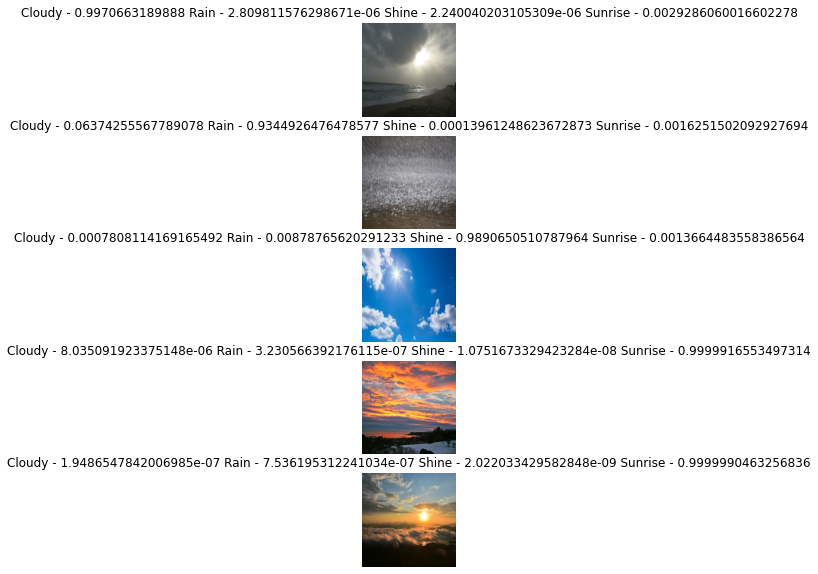

In [503]:
show_results_by_pictures(lenet_model)